In [4]:
import numpy as np
from scipy.optimize import fsolve

# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 10*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  50*2.54,
    'lines.linewidth':2,
    'legend.fontsize': 7*2.54,
    'xtick.labelsize': 10*2.54,
    'ytick.labelsize': 10*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)

In [925]:
def carry_PHS(state, theta, chi):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2)-1j*np.sin(theta/2)*np.sin(chi), -np.sin(theta/2)*np.cos(chi)],[np.sin(theta/2)*np.cos(chi), np.cos(theta/2)+1j*np.sin(theta/2)*np.sin(chi)]])
	final_state = np.dot(U, state)

	return final_state    

def carry(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def blue_carry(state, theta):
	'''
	blue carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number plus 1
	|1>-->|0>, phonon number minus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, down level minus 1
	up_state = carry_state_up[0]
	down_state_minus = carry_state_up[1]
	down_state_minus_0 = state_up[0][0]  # blue carry can not drive the phonon=0 && up level
	down_state_minus = np.delete(down_state_minus, 0)
	down_state_minus = np.insert(down_state_minus, len(down_state_minus)-1, 0)
	# after U operation, up level plus 1
	up_state_plus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_plus = np.insert(up_state_plus, 0, down_state_minus_0)
	up_state_plus = np.delete(up_state_plus, len(up_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_plus
	down = down_state_minus + down_state
	final_state = np.vstack((up, down))

	return final_state

def red_carry(state, theta):
	'''
	red carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number minus 1
	|1>-->|0>, phonon number plus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, up level minus 1
	up_state_minus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_minus_0 = state_down[1][0] # red carry can not drive the phonon=0 && down level
	up_state_minus = np.delete(up_state_minus,0)
	up_state_minus = np.insert(up_state_minus,len(up_state_minus)-1,0)
	# after U operation, down level plus 1
	up_state = carry_state_up[0]
	down_state_plus = carry_state_up[1]
	down_state_plus = np.insert(down_state_plus,0,up_state_minus_0)
	down_state_plus = np.delete(down_state_plus,len(down_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_minus
	down = down_state_plus + down_state
	final_state = np.vstack((up, down))

	return final_state

def Operator(up_state, down_state, func, theta):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = func(state, theta)

	return state[0], state[1]

def operator(up_state, down_state, theta, chi):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = carry_PHS(state, theta, chi)

	return state[0], state[1]

def one_step_1(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T2R2T1R1
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state


# def One_step_1(state, theta_1, theta_2):
# 	'''
# 	one step of complete quantum walk
# 	may with the help of auxiliary level
# 	input state of three level
# 	output state of three level
# 	T1:up-->right
# 	t2:down-->left 
# 	T2R2T1R1
# 	'''
# 	up_state = state[0]
# 	down_state = state[1]
# 	aux_state = state[2]
# 	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
# 	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
# 	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
# 	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
# 	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
# 	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)
# 	up_state[0] = - up_state[0]
# 	state = np.vstack((up_state, down_state, aux_state))
# 	return state

def one_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def One_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = - up_state[0]
	state = np.vstack((up_state, down_state, aux_state))
	return state



def One_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = - up_state[0]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step(state, theta_1, theta_2, chi):
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = operator(up_state, down_state, theta_2, chi)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = operator(aux_state, down_state, theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = up_state[0]
	state = np.vstack((up_state, down_state, aux_state))
	return state
	
	state = np.vstack((up_state, down_state, aux_state))
	return state


def N_step_1(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_1(state, theta_1, theta_2)
	return state

def n_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2(state, theta_1, theta_2)
	return state

def N_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_2(state, theta_1, theta_2)
	return state

def n_step(state, theta_1, theta_2, chi, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step(state, theta_1, theta_2, chi)
	return state


# def N_step_3(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_3(state, theta_1, theta_2)
# 	return state

# def N_step_4(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_4(state, theta_1, theta_2)
# 	return state

# def N_STEP_2(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = One_step_2(state, theta_1, theta_2)
# 	return state

def n_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_4(state, theta_1, theta_2)
	return state

def N_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_4(state, theta_1, theta_2)
	return state


# def N_STEP_1(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = One_step_1(state, theta_1, theta_2)
# 	return state

# def N_STEP_3(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = One_step_3(state, theta_1, theta_2)
# 	return state

# def N_step_5(state, theta, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_5(state, theta)
# 	return state


In [948]:
M = 1000
n = 1
N = 500
p1 = np.zeros(801)
p2 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state1 = n_step_2(init_state, theta, theta_1, N=50)
    state2 = n_step_2(init_state, theta, -np.pi/2, N=50)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1[i] = P1[0] + P1[1] 
    p2[i] = P2[0] + P2[1]


In [949]:
M = 1000
n = 1
N = 500
p3 = np.zeros(801)
p4 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state3 = n_step_2(init_state, theta_1, theta, N=50)
    state4 = n_step_2(init_state, -theta_1, theta, N=50)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p3[i] = P3[0] + P3[1] 
    p4[i] = P4[0] + P4[1] 


In [950]:
M = 1000
n = 1
N = 500
p5 = np.zeros(801)
p6 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state5 = n_step_4(init_state, theta, theta_1, N=50)
    state6 = n_step_4(init_state, theta, -np.pi/2, N=50)
    P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
    P6 = abs(state6[0])**2 + abs(state6[1])**2 + abs(state6[2])**2
    p5[i] = P5[0] + P5[1] 
    p6[i] = P6[0] + P6[1] 
    


In [951]:
M = 1000
n = 1
N = 500
p7 = np.zeros(801)
p8 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state7 = n_step_4(init_state, theta_1, theta, N=50)
    state8 = n_step_4(init_state, -theta_1, theta, N=50)
    P7 = abs(state7[0])**2 + abs(state7[1])**2 + abs(state7[2])**2
    P8 = abs(state8[0])**2 + abs(state8[1])**2 + abs(state8[2])**2
    p7[i] = P7[0] + P7[1] 
    p8[i] = P8[0] + P8[1] 

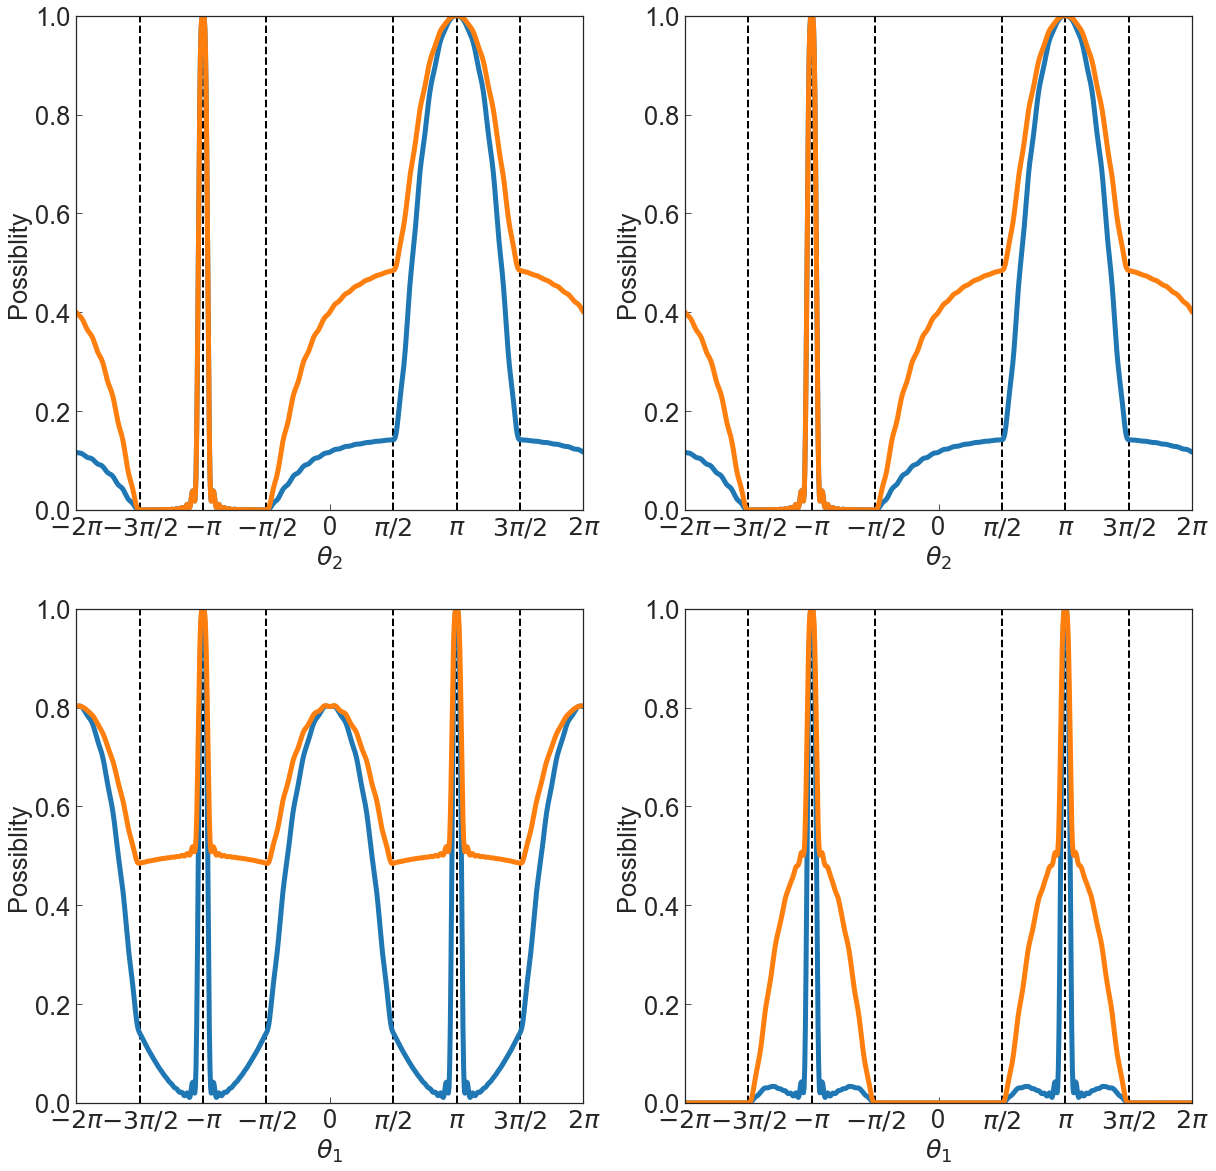

In [1071]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.plot(theta_2, p1,linewidth=5)
plt.plot(theta_2, p5,linewidth=5)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.ylabel('Possiblity')
plt.xlabel(r'$\theta_2$')

plt.subplot(2, 2, 2)
plt.plot(theta_2, p2,linewidth=5)
plt.plot(theta_2, p6,linewidth=5)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,(r'$-2\pi$',r'$-3\pi/2$',r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.ylabel('Possiblity')
plt.xlabel(r'$\theta_2$')

plt.subplot(2, 2, 3)
plt.plot(theta_2, p3,linewidth=5)
plt.plot(theta_2, p7,linewidth=5)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.ylabel('Possiblity')
plt.xlabel(r'$\theta_1$')

plt.subplot(2, 2, 4)
plt.plot(theta_2, p4,linewidth=5)
plt.plot(theta_2, p8,linewidth=5)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.ylabel('Possiblity')
plt.xlabel(r'$\theta_1$')

plt.savefig('../fig/bound_state_3.pdf')

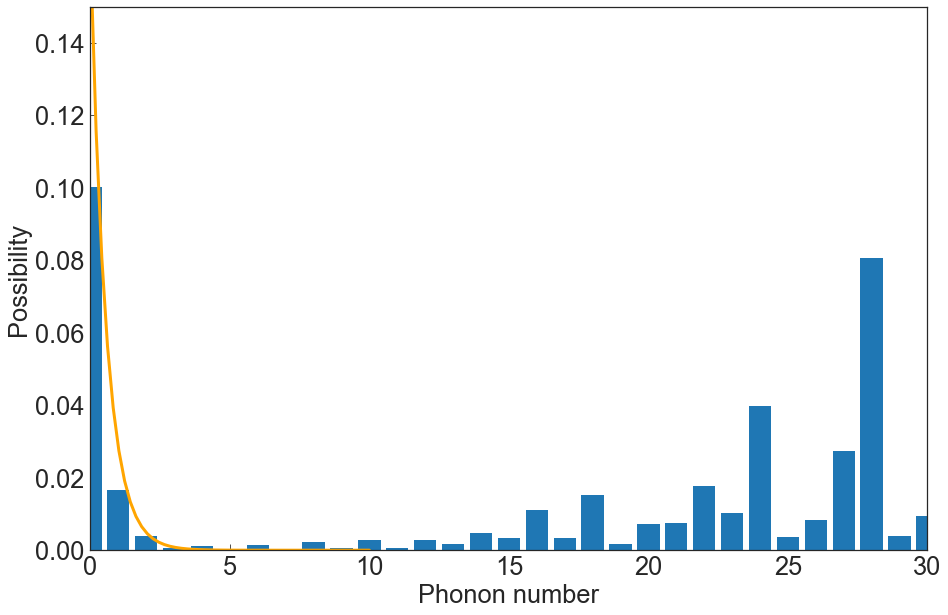

In [957]:
# state = N_step(init_state, theta_1, theta_2, N=50)
# plot result
# P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
# phonon = range(len(P))
# # plt.scatter(phonon, P, s=1000*P)
# print('total pro', sum(P))
# plt.bar(range(len(P)),P)

# plt.title('$\varepsilon$',fontsize=20)

# plt.figure(figsize=(20,20))
# for i,theta in enumerate(theta_1):
#     state = N_step(init_state, theta, theta_2, N=N)
#     P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     plt.subplot(6,4,i+1)
#     plt.xlabel('theta=%f'%theta)
#     plt.bar(range(5),P[:5])
## bar plot
plt.figure(figsize=(15, 10))
x = np.linspace(0,10)
def f(x):
    return pow((np.sqrt(2)-1),x)**2*(1-(np.sqrt(2)-1)**2)/5
p = np.zeros(50)
for i in range(50):
    state = n_step_2(init_state, 0, np.pi/2, N=50)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p[i] = P[i]
plt.xlim((0,30))
plt.ylim((0,0.15))
plt.bar(range(50),p)
plt.xlabel('Phonon number')
plt.ylabel('Possibility')
plt.plot(x, f(x),color='orange',linewidth=3)
plt.savefig('../fig/bound_2.pdf')

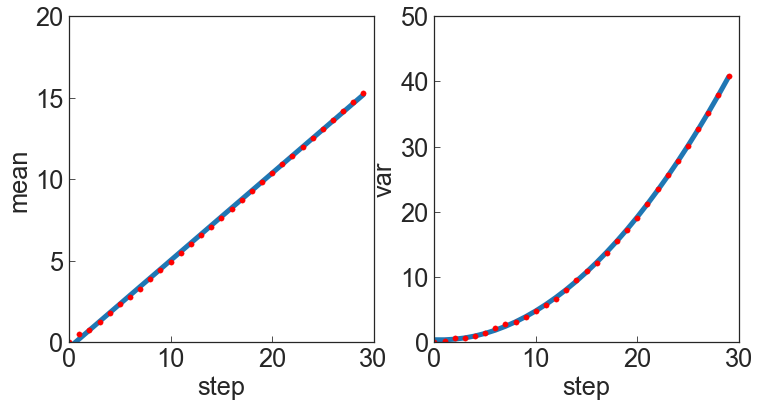

In [970]:
from scipy import optimize
 
def f_1(x, A, B):
    return A * x + B
def f_2(x, A, B, C):
    return A*x**2 +B*x + C


plt.figure(figsize=(12, 6))
mean = np.zeros(30)
var = np.zeros(30)
for i in range(30):
    state = n_step_2(init_state, 0, np.pi/2, N=i)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    mean[i] = 0
    for j in range(50):
        mean[i] = mean[i] + P[j]*j
        var[i] = var[i] + P[j]*j**2
    mean[i] = mean[i]
    var[i] =  var[i] - mean[i]**2
plt.subplot(1, 2, 1)
A1, B1 = optimize.curve_fit(f_1, range(30), mean)[0]
x1 = range(30)
y1 = A1 * x1 + B1
plt.plot(x1,y1, linewidth=5, zorder=1)
plt.scatter(range(30), mean, c='r', s=30, zorder=2)
plt.xlim((0,30))
plt.ylim((0,20))
plt.xlabel('step')
plt.ylabel('mean')
plt.subplot(1, 2, 2)
a=np.polyfit(x1, var, 2)#用2次多项式拟合x，y数组
b=np.poly1d(a)#拟合完之后用这个函数来生成多项式对象
c=b(x1)#生成多项式对象之后，就是获取x在这个多项式处的值
plt.plot(x1, c, linewidth=5, zorder=1)
plt.scatter(range(30), var, c='r', s=30, zorder=2)
plt.xlim((0,30))
plt.ylim((0,50))
plt.xlabel('step')
plt.ylabel('var')
plt.savefig('../fig/bound_3.pdf')

In [ ]:
# plot thermal picture
# array=np.zeros((N,M))
# for i in range(0,N):
# 	state = N_step(init_state, theta_1, theta_2, N=i)
# 	P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
# 	array[i]=P
# plt.figure()
# plt.xlim(0,N)
# plt.xlabel('phonon')
# plt.ylabel('step')
# plt.imshow(array)
# plt.colorbar()

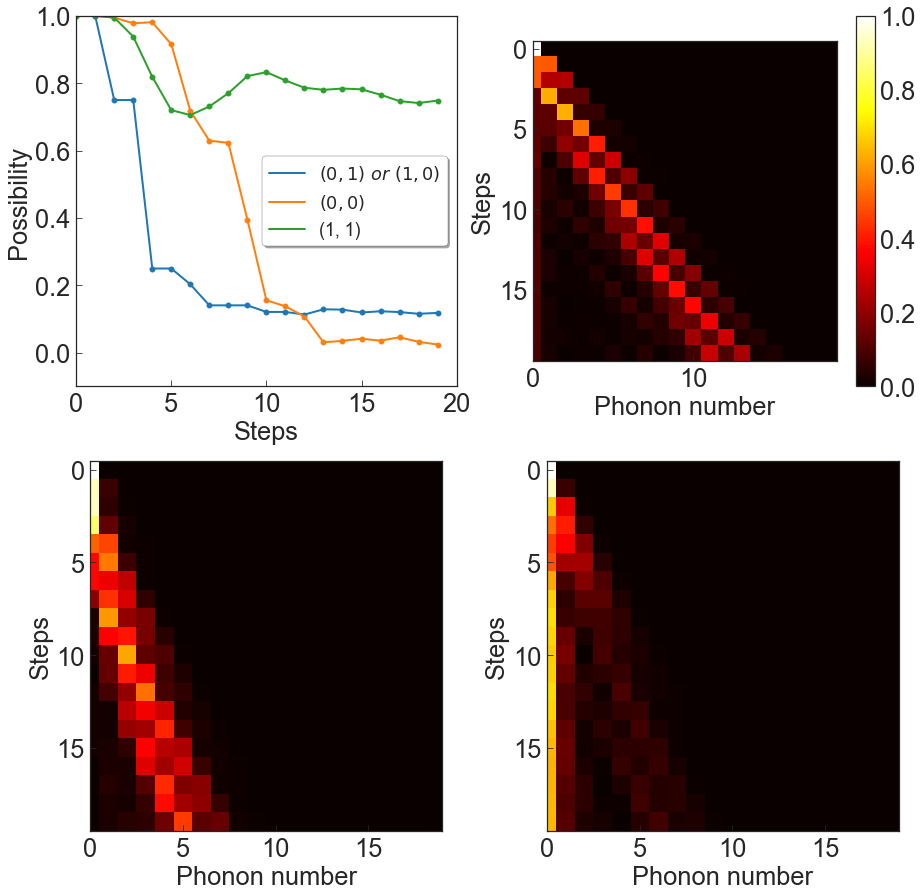

In [945]:
plt.figure(figsize=(15, 15))
M = 1000
n = 1
N = 500
loc1 = np.zeros(20)
loc2 = np.zeros(20)
loc3 = np.zeros(20)
heat1 = np.zeros((20,20))
heat2 = np.zeros((20,20))
heat3 = np.zeros((20,20))
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
# up_state[0] = 1/np.sqrt(2)
# down_state[0] = 1/np.sqrt(2)
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i in range(20):
    state_1 = n_step_2(init_state, 0, np.pi/2, N=i)
    state_2 = n_step_2(init_state, -3*np.pi/4, np.pi/2, N=i)
    state_3 = n_step_2(init_state, 3*np.pi/4, np.pi/2, N=i)
    P_1 = abs(state_1[0])**2 + abs(state_1[1])**2 + abs(state_1[2])**2
    loc1[i] = P_1[0] + P_1[1]
    heat1[i] = P_1[0:20]
    P_2 = abs(state_2[0])**2 + abs(state_2[1])**2 + abs(state_2[2])**2
    loc2[i] = P_2[0] + P_2[1]
    heat2[i] = P_2[0:20]
    P_3 = abs(state_3[0])**2 + abs(state_3[1])**2 + abs(state_3[2])**2
    loc3[i] = P_3[0] + P_3[1]
    heat3[i] = P_3[0:20]
plt.subplot(2, 2, 1)
plt.xlim((0,20))
plt.ylim((-0.1,1))
plt.xlabel('Steps')
plt.ylabel('Possibility')
plt.scatter(range(20), loc1)
plt.plot(range(20), loc1, label='$(0, 1)\ or\ (1, 0)$')
plt.scatter(range(20), loc2)
plt.plot(range(20), loc2, label='$(0, 0)$')
plt.scatter(range(20), loc3)
plt.plot(range(20), loc3, label='(1, 1)')
plt.legend(loc='best')
my_y_ticks = [0, 5, 10, 15]
plt.subplot(2, 2, 2)
plt.xlim(0, 19)
plt.yticks(my_y_ticks,(0,5,10,15))
plt.xlabel('Phonon number')
plt.ylabel('Steps')
plt.imshow(heat1, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.xlim(0, 19)
plt.yticks(my_y_ticks,(0,5,10,15))
plt.xlabel('Phonon number')
plt.ylabel('Steps')
plt.imshow(heat2, cmap='hot', interpolation='nearest')
plt.subplot(2, 2, 4)
plt.xlim(0, 19)
plt.yticks(my_y_ticks,(0,5,10,15))
plt.xlabel('Phonon number')
plt.ylabel('Steps')
plt.imshow(heat3, cmap='hot', interpolation='nearest')
plt.savefig('../fig/bound_4.pdf')

In [461]:
alpha = np.arctan(cos(theta_1/2+theta_2/2)/(cos(theta_1/2)*cos(theta_2/2)))
yeta = (1 + sin(theta_1/2)*sin(theta_2/2))/np.sqrt((cos(theta_1/2)*cos(theta_2/2))**2+(cos((theta_1+theta_2)/2)*sin(np.pi/3))**2)


0.837250752772137


In [474]:
theta_1 = np.pi/7
theta_2 = np.pi/2
yeta = (1 - cos(np.pi/3)**2*sin(theta_1/2)*sin(theta_2/2))/np.sqrt((cos(theta_1/2)*cos(theta_2/2)+sin(np.pi/3)**2*sin(theta_1)*sin(theta_2))**2+(sin((theta_1+theta_2)/2)*sin(np.pi/3))**2)
print(yeta)

0.7673023541730418


In [797]:
from numpy import cos,sin
def f1(theta_1, theta_2, chi, k):
    return np.arccos(-cos(k)*cos(theta_1/2)*cos(theta_2/2)+cos(chi)**2*sin(theta_1/2)*sin(theta_2/2)-sin((theta_1+theta_2)/2)*sin(chi)*sin(k)-cos(k)*sin(chi)**2*sin(theta_1/2)*sin(theta_2/2))
def f2(theta_1, theta_2, chi, k):
    return np.arccos(cos(k)*cos(theta_1/2)*cos(theta_2/2)-sin(theta_1/2)*sin(theta_2/2)*cos(chi))
def f3(chi, k):
    return np.arccosh(-cos(k)*cos(theta_1/2)*cos(theta_2/2)+cos(chi)**2*sin(theta_1/2)*sin(theta_2/2)-sin((theta_1+theta_2)/2)*sin(chi)*sin(k)-cos(k)*sin(chi)**2*sin(theta_1/2)*sin(theta_2/2))
def f4(theta_1, theta_2, chi):
    return (1 - cos(chi)**2*sin(theta_1/2)*sin(theta_2/2))/np.sqrt((cos(theta_1/2)*cos(theta_2/2)+sin(chi)**2*sin(theta_1/2)*sin(theta_2/2))**2+(sin((theta_1+theta_2)/2)*sin(chi))**2)

In [896]:
f4(theta_1, theta_2, 0.6342677422703419)
chi_0 = 0.6342677422703419

In [774]:
f3(np.pi/4, -2.149544932992765)
k_1 = -2.149544932992765
f3(np.pi/4, -2.80936345001634)
k_2 = -2.80936345001634

In [893]:
def circle(count=1000):
    xarr=[]
    yarr=[]
    for i in range(count):
        j = float(i)/count * 2 * np.pi
        xarr.append(np.cos(j))
        yarr.append(np.sin(j))
    line, =plt.plot(xarr,yarr,color = 'blue',linewidth=2,linestyle="-")
    line.set_dashes((20,4))
def Circle(theta_1, theta_2, count=1000):
    xarr=[]
    yarr=[]
    for i in range(count):
        j = float(i)/count * (theta_2-theta_1) + theta_1
        xarr.append(np.cos(j))
        yarr.append(np.sin(j))
    line, =plt.plot(xarr,yarr,color = 'green',linewidth=10)

2.4910751795845587 0.020609570082583777


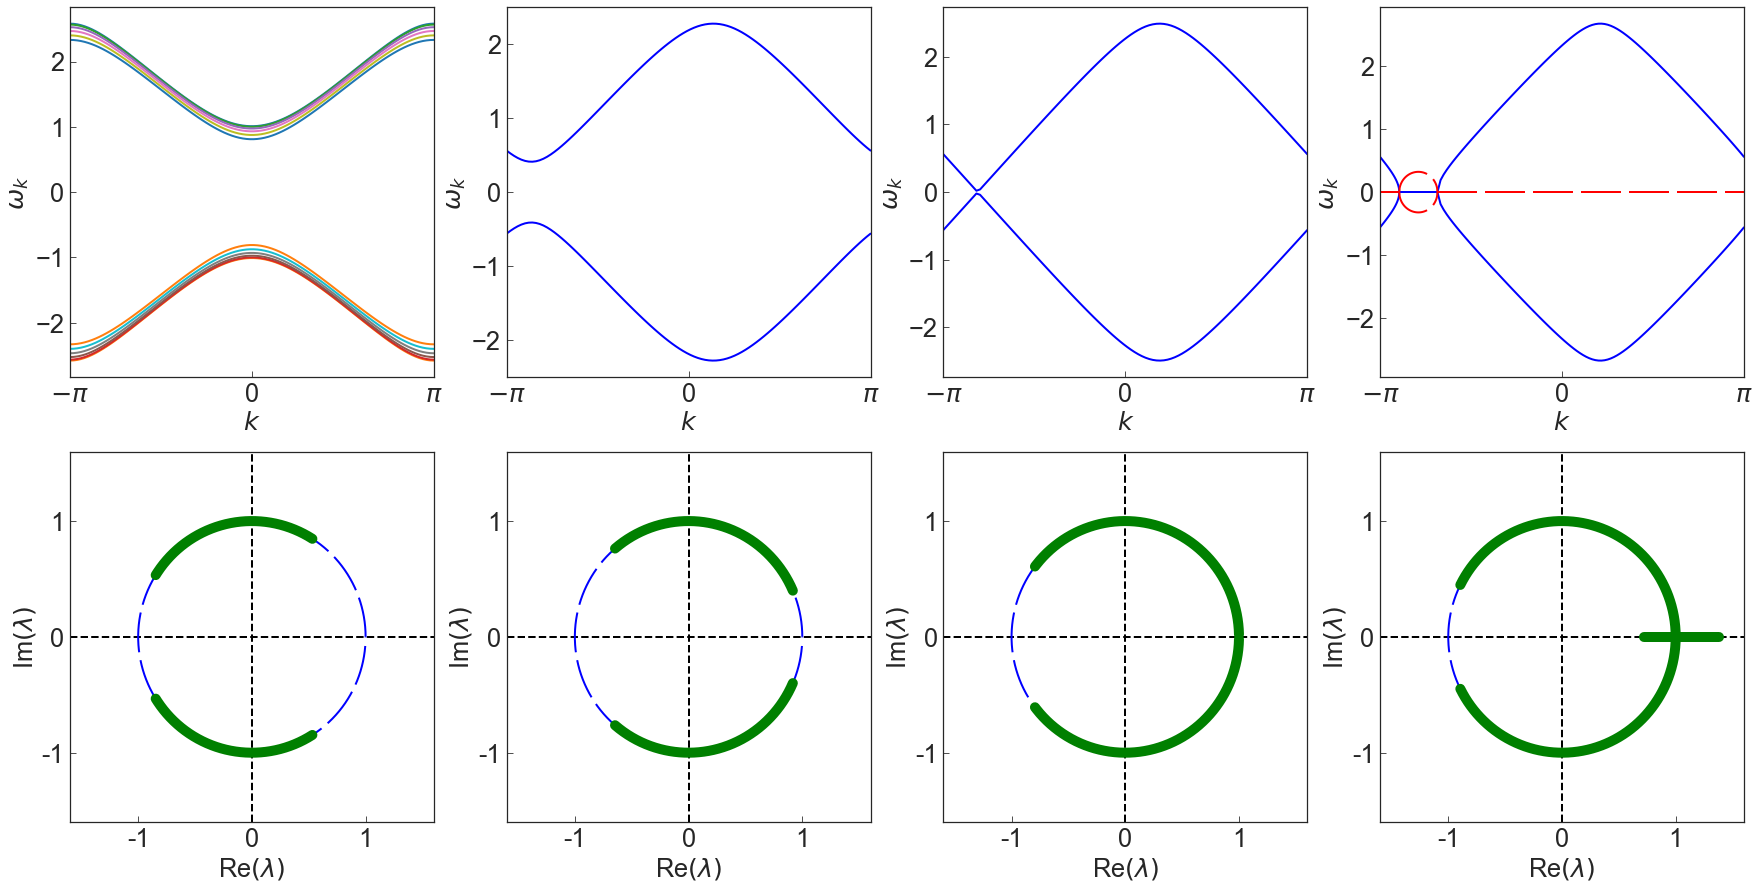

In [939]:
plt.figure(figsize=(30,15))
k = np.linspace(-np.pi, np.pi, 100)
theta_1 = np.pi/7
theta_2 = np.pi/2
chi_0 = 0.6342677422703419
chi = np.linspace(0, np.pi/2, 6)
chi_1 = np.pi/4
Chi = np.pi/8
my_x_ticks = [0, -np.pi, np.pi]
x_ticks = [0, -1, 1]
y_ticks = [0, -1, 1]
plt.subplot(2,4,1)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
for c in chi:
    plt.plot(k, f2(theta_1, theta_2, c, k))
    plt.plot(k, -f2(theta_1, theta_2, c, k))
plt.subplot(2,4,5)
plt.xlim((-1.6, 1.6))
plt.ylim((-1.6, 1.6))
plt.vlines(0, -1.6, 1.6, linestyles = "dashed")
plt.hlines(0, -1.6, 1.6, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
circle()
Circle(f2(theta_1, theta_2, 0, 0), f2(theta_1, theta_2, 0, np.pi))
Circle(-f2(theta_1, theta_2, 0, 0), -f2(theta_1, theta_2, 0, np.pi))
plt.subplot(2,4,2)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.plot(k, f1(theta_1, theta_2, Chi, k), c='b')
plt.plot(k, -f1(theta_1, theta_2, Chi, k),c='b')
t_max = max(f1(theta_1, theta_2, Chi, k))
t_min = min(f1(theta_1, theta_2, Chi, k))
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.subplot(2,4,6)
plt.xlim((-1.6, 1.6))
plt.ylim((-1.6, 1.6))
plt.vlines(0, -1.6, 1.6, linestyles = "dashed")
plt.hlines(0, -1.6, 1.6, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
circle()
Circle(t_min, t_max)
Circle(-t_min, -t_max)
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.subplot(2,4,3)
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.plot(k, f1(theta_1, theta_2, chi_0, k), c='b')
plt.plot(k, -f1(theta_1, theta_2, chi_0, k), c='b')
t_max_0 = max(f1(theta_1, theta_2, chi_0, k))
t_min_0 = min(f1(theta_1, theta_2, chi_0, k))
print(t_max_0, t_min_0)
plt.subplot(2,4,7)
plt.xlim((-1.6, 1.6))
plt.ylim((-1.6, 1.6))
plt.vlines(0, -1.6, 1.6, linestyles = "dashed")
plt.hlines(0, -1.6, 1.6, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
circle()
Circle(t_min_0, t_max_0)
Circle(-t_min_0, -t_max_0)
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.subplot(2,4,4)
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
k1 = np.linspace(-np.pi,k_2,100)
k2 = np.linspace(k_1,np.pi,100)
k3 = np.linspace(k_2,k_1,100)
plt.plot(k1, f1(theta_1, theta_2, chi_1, k1), c='b')
plt.plot(k2, f1(theta_1, theta_2, chi_1, k2), c='b')
plt.plot(k1, -f1(theta_1, theta_2, chi_1, k1), c='b')
plt.plot(k2, -f1(theta_1, theta_2, chi_1, k2), c='b')
t_max_1 = max(f1(theta_1, theta_2, chi_1, k2))
t_min_1 = 0
plt.plot(k3, np.zeros(100), c='b')
line1, = plt.plot(k3, f3(chi_1, k3), c='r', linestyle="-")
line2, = plt.plot(k3, -f3(chi_1, k3), c='r', linestyle="-")
line3, = plt.plot(k1, np.zeros(100), c='r', linestyle="-")
line4, = plt.plot(k2, np.zeros(100), c='r', linestyle="-")
t_max_2 = max(f3(chi_1, k3))
line1.set_dashes((20,4))
line2.set_dashes((20,4))
line3.set_dashes((20,4))
line4.set_dashes((20,4))
plt.subplot(2,4,8)
plt.xlim((-1.6, 1.6))
plt.ylim((-1.6, 1.6))
plt.vlines(0, -1.6, 1.6, linestyles = "dashed")
plt.hlines(0, -1.6, 1.6, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
circle()
Circle(t_min_1, t_max_1)
Circle(-t_min_1, -t_max_1)
plt.plot(np.linspace(np.exp(-t_max_2),np.exp(t_max_2),50), np.zeros(50), color = 'green', linewidth=10)
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.savefig('../fig/symmetry.pdf')

In [82]:
from numpy import cos,sin
def f1(theta_1, theta_2, chi, k):
    return np.arccos((cos(k)*cos(theta_1/2)*cos(theta_2/2)-cos(chi)**2*sin(theta_1/2)*sin(theta_2/2)+sin((theta_1+theta_2)/2)*sin(chi)*sin(k)-cos(k)*sin(chi)**2*sin(theta_1/2)*sin(theta_2/2)))
def f2(theta_1, theta_2, chi, k):
    return np.arccos(cos(k)*cos(theta_1/2)*cos(theta_2/2)-sin(theta_1/2)*sin(theta_2/2)*cos(chi))

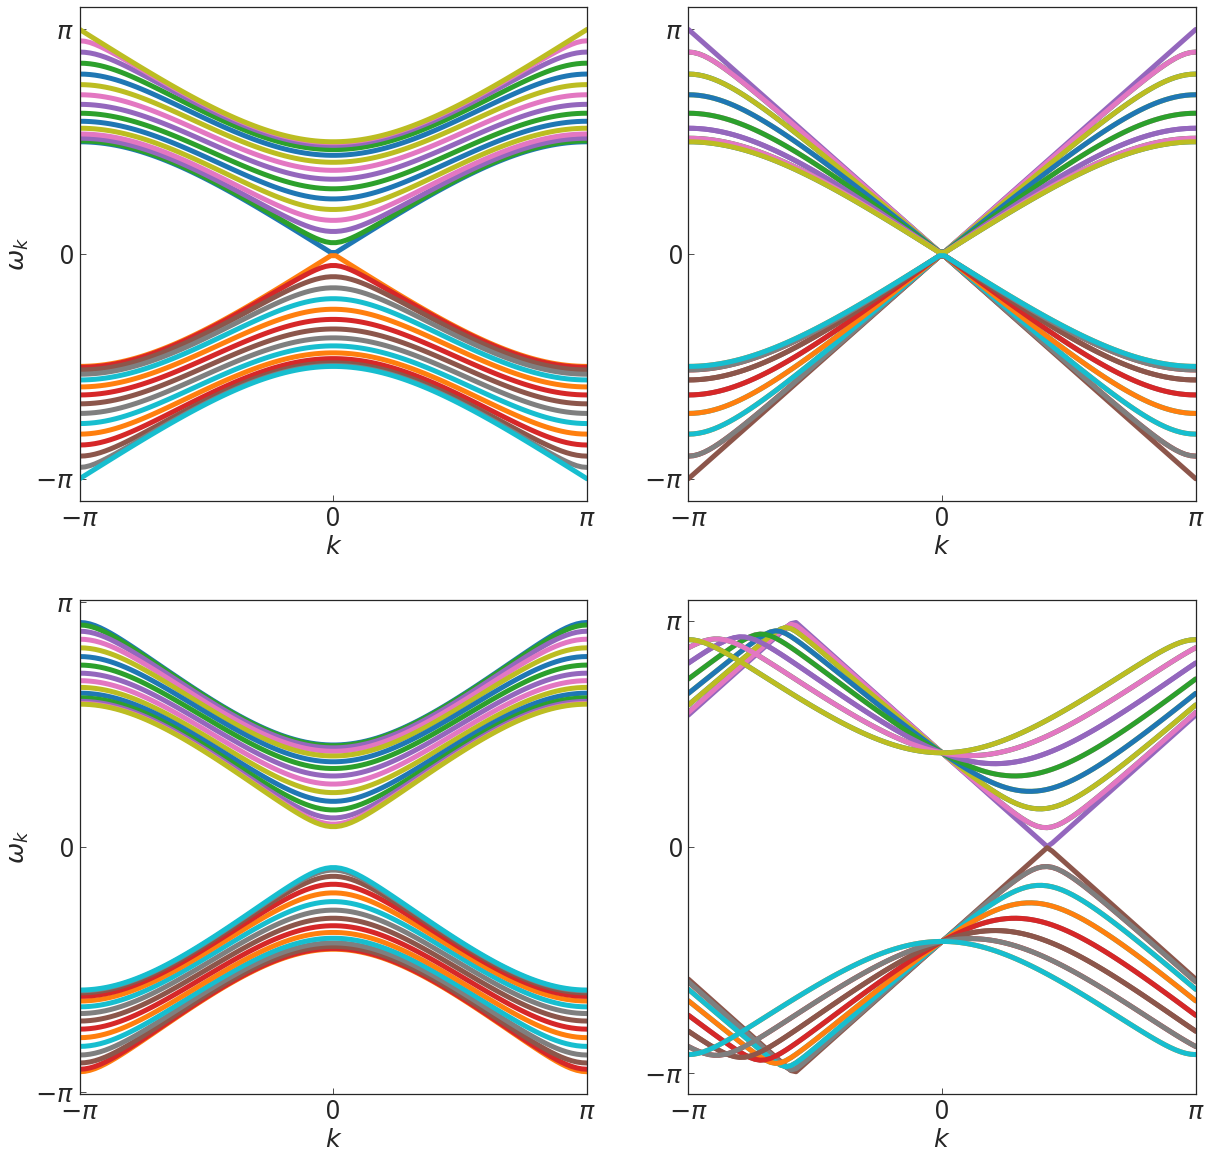

In [109]:
chi = np.linspace(0, np.pi, 15)
k = np.linspace(-np.pi, np.pi, 100)
theta_1 = -np.pi/2
theta_2 = np.pi/2
my_x_ticks = [0, -np.pi, np.pi]
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.yticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
for c in chi:
    plt.plot(k, f2(theta_1, theta_2, c, k),lw=5)
    plt.plot(k, -f2(theta_1, theta_2, c, k),lw=5)
plt.subplot(2,2,2)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.yticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.xlabel('$k$')
for c in chi:
    plt.plot(k, f1(theta_1, theta_2, c, k),lw=5)
    plt.plot(k, -f1(theta_1, theta_2, c, k),lw=5)
plt.subplot(2,2,3)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.yticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
for c in chi:
    plt.plot(k, f2(np.pi/3, theta_2, c, k),lw=5)
    plt.plot(k, -f2(np.pi/3, theta_2, c, k),lw=5)
plt.subplot(2,2,4)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.yticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.xlabel('$k$')
for c in chi:
    plt.plot(k, f1(np.pi/3, theta_2, c, k),lw=5)
    plt.plot(k, -f1(np.pi/3, theta_2, c, k),lw=5)
    
plt.savefig('../fig/bound_state')

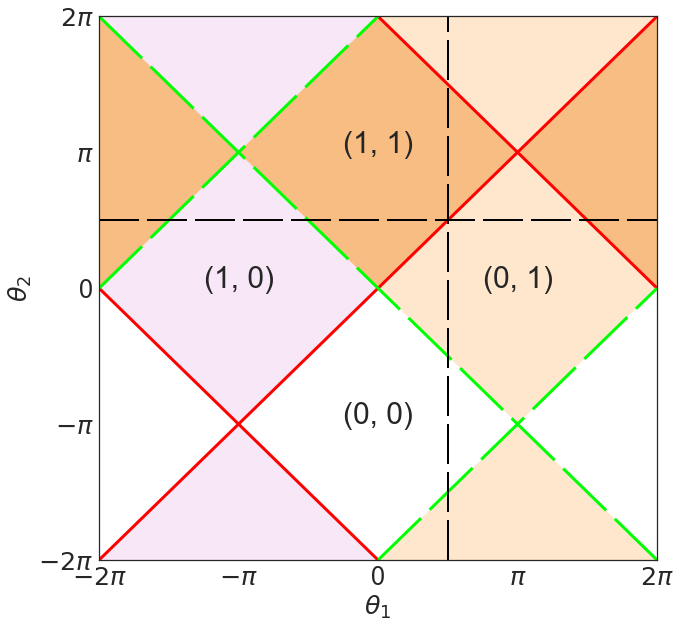

In [1068]:
plt.figure(figsize=(10,10))
plt.xlim((-2*np.pi, 2*np.pi))
plt.xticks([-2*np.pi, 2*np.pi, -np.pi, np.pi, 0], ('$-2\pi$', '$2\pi$', '$-\pi$', '$\pi$', '0'))
plt.ylim((-2*np.pi, 2*np.pi))
plt.yticks([-2*np.pi, 2*np.pi, -np.pi, np.pi, 0], ('$-2\pi$', '$2\pi$', '$-\pi$', '$\pi$', '0'))

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')

T1 = np.linspace(-2*np.pi, 2*np.pi, 100)
T2 = np.linspace(0, 2*np.pi, 50)
T3 = np.linspace(-2*np.pi, 0, 50)
y1 = T3

y2 = -T2+2*np.pi
y3 = -T3-2*np.pi
plt.plot(T1, T1, c='r', linewidth=3)
plt.plot(T2, -T2+2*np.pi, c='r', linewidth=3)
plt.plot(T3, -T3-2*np.pi, c='r', linewidth=3)
y4 = -T3
y5 = T2-2*np.pi
y6 = T3+2*np.pi
line_1, = plt.plot(T1, -T1, c='#00FF00', linewidth=3, linestyle="-")
line_1.set_dashes((20,4))
line_2, = plt.plot(T2, T2-2*np.pi, c='#00FF00', linewidth=3, linestyle="-")
line_2.set_dashes((20,4))
line_3, = plt.plot(T3, T3+2*np.pi, c='#00FF00', linewidth=3, linestyle="-")
line_3.set_dashes((20,4))
line_4, = plt.plot(np.pi*np.ones(100)/2, T1, c='black', linewidth=2, linestyle="-")
line_4.set_dashes((20,4))
line_5, = plt.plot(T1, np.pi*np.ones(100)/2, c='black', linewidth=2, linestyle="-")
line_5.set_dashes((20,4))


plt.fill([-np.pi, 0, -2*np.pi], [np.pi, 2*np.pi, 2*np.pi], color='#F7E7F7')
plt.fill([-np.pi, -2*np.pi, -np.pi, 0], [np.pi, 0, -np.pi, 0], color='#F7E7F7')
plt.fill([-np.pi, -2*np.pi, 0], [-np.pi, -2*np.pi, -2*np.pi], color='#F7E7F7')

plt.fill([np.pi, 0, 2*np.pi], [np.pi, 2*np.pi, 2*np.pi], color='#FFE7CE')
plt.fill([np.pi, 2*np.pi, np.pi, 0], [np.pi, 0, -np.pi, 0], color='#FFE7CE')
plt.fill([np.pi, 2*np.pi, 0], [-np.pi, -2*np.pi, -2*np.pi], color='#FFE7CE')

plt.fill([-np.pi, -2*np.pi, -2*np.pi], [np.pi, 2*np.pi, 0], color='#F8BD82')
plt.fill([-np.pi, 0, np.pi, 0], [np.pi, 0, np.pi, 2*np.pi], color='#F8BD82')
plt.fill([np.pi, 2*np.pi, 2*np.pi], [np.pi, 2*np.pi, 0], color='#F8BD82')

plt.fill([-np.pi, -2*np.pi, -2*np.pi], [-np.pi, -2*np.pi, 0], c='w')
plt.fill([-np.pi, 0, np.pi, 0], [-np.pi, 0, -np.pi, -2*np.pi], c='w')
plt.fill([np.pi, 2*np.pi, 2*np.pi], [-np.pi, -2*np.pi, 0], c='w')


plt.text(0, np.pi, '(1, 1)', ha='center', fontsize=30)
plt.text(-np.pi, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(np.pi, 0, '(0, 1)', ha='center', fontsize=30)
plt.text(0, -np.pi, '(0, 0)', ha='center', fontsize=30)
plt.savefig('../fig/phase.pdf')

In [1073]:
def N_step_destruc(state, theta_1, theta_2, N_1, N_2):
    for i in range(N_1):
        state = one_step_4(state, theta_1, theta_2)
    state_1 = state
    for i in range(N_2):
        state_1 = one_step_4(state_1, theta_1, -theta_2)
    return state_1

In [1135]:
M = 1000
n = 1
N = 500
p10 = np.zeros(801)
p11 = np.zeros(801)
p14 = np.zeros(801)
p15 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-np.pi/2,np.pi/2,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state10 = N_step_destruc(init_state, theta, theta_1, N_1=30, N_2=30)
    state11 = N_step_destruc(init_state, theta, -theta_1, N_1=30, N_2=30)
    P10 = abs(state10[0])**2 + abs(state10[1])**2 + abs(state10[2])**2
    P11 = abs(state11[0])**2 + abs(state11[1])**2 + abs(state11[2])**2
    p10[i] = P10[0] + P10[1] 
    p11[i] = P11[0] + P11[1]
    state14 = N_step_destruc(init_state, theta, theta_1, N_1=30, N_2=90)
    state15 = N_step_destruc(init_state, theta, -theta_1, N_1=30, N_2=90)
    P14 = abs(state14[0])**2 + abs(state14[1])**2 + abs(state14[2])**2
    P15 = abs(state15[0])**2 + abs(state15[1])**2 + abs(state15[2])**2
    p14[i] = P14[0] + P14[1] 
    p15[i] = P15[0] + P15[1]



In [1139]:
M = 1000
n = 1
N = 500
p12 = np.zeros(801)
p13 = np.zeros(801)
p16 = np.zeros(801)
p17 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-np.pi/2,np.pi/2,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state12 = N_step_destruc(init_state, theta_1, theta, N_1=30, N_2=30)
    state13 = N_step_destruc(init_state, -theta_1, theta, N_1=30, N_2=30)
    P12 = abs(state12[0])**2 + abs(state12[1])**2 + abs(state12[2])**2
    P13 = abs(state13[0])**2 + abs(state13[1])**2 + abs(state13[2])**2
    p12[i] = P12[0] + P12[1] 
    p13[i] = P13[0] + P13[1]
    state16 = N_step_destruc(init_state, theta_1, theta, N_1=30, N_2=90)
    state17 = N_step_destruc(init_state, -theta_1, theta, N_1=30, N_2=90)
    P16 = abs(state16[0])**2 + abs(state16[1])**2 + abs(state16[2])**2
    P17 = abs(state17[0])**2 + abs(state17[1])**2 + abs(state17[2])**2
    p16[i] = P16[0] + P16[1] 
    p17[i] = P17[0] + P17[1]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


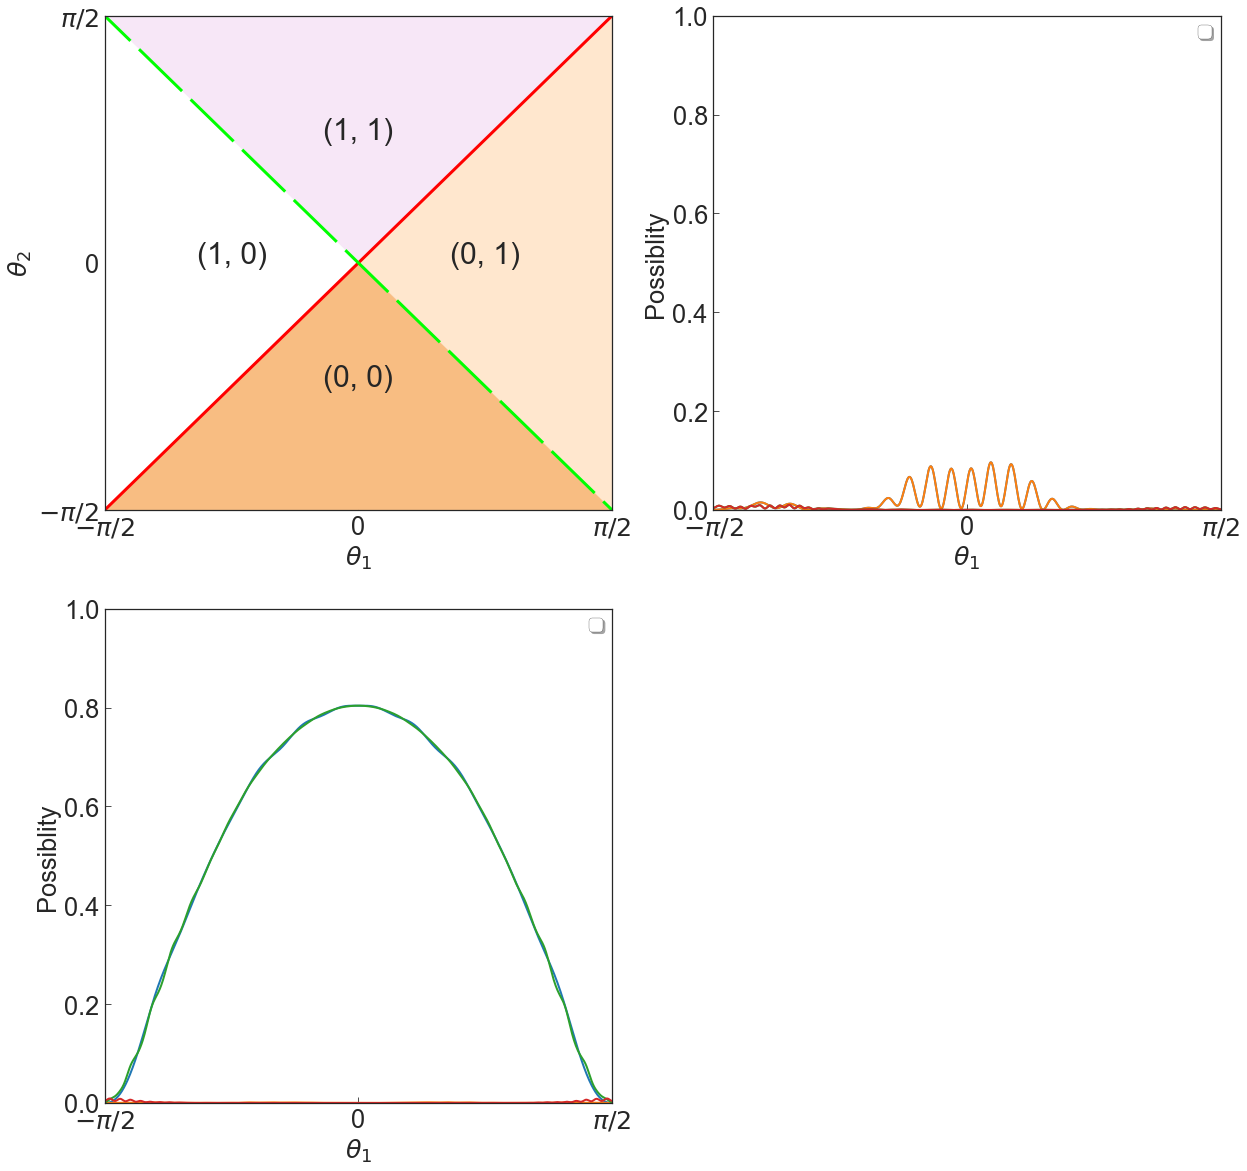

In [1141]:
plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.xlim((-np.pi/2, np.pi/2))
plt.xticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
T4 = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(T4, T4, c='r', linewidth=3)
line_6, = plt.plot(T1, -T1, c='#00FF00', linewidth=3, linestyle="-")
line_6.set_dashes((20,4))
plt.fill([0, -np.pi/2, np.pi/2], [0, np.pi/2, np.pi/2], color='#F7E7F7')
plt.fill([0, np.pi/2, np.pi/2], [0, np.pi/2, -np.pi/2], color='#FFE7CE')
plt.fill([0, np.pi/2, -2*np.pi], [0, -np.pi/2, -np.pi/2], color='#F8BD82')
plt.fill([0, -np.pi/2, -np.pi/2], [0, np.pi/2, -np.pi/2], c='w')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.text(0, np.pi/4, '(1, 1)', ha='center', fontsize=30)
plt.text(-np.pi/4, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(np.pi/4, 0, '(0, 1)', ha='center', fontsize=30)
plt.text(0, -np.pi/4, '(0, 0)', ha='center', fontsize=30)
A=[np.pi/4, np.pi/2]
B=[np.pi/4, -np.pi/2]

plt.subplot(2,2,2)
plt.plot(theta_2, p10)
plt.plot(theta_2, p11)
plt.plot(theta_2, p14)
plt.plot(theta_2, p15)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-np.pi/2, np.pi/2))
plt.xticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
plt.ylabel('Possiblity')
plt.xlabel(r'$\theta_1$')
plt.legend()
plt.subplot(2,2,3)
plt.plot(theta_2, p12)
plt.plot(theta_2, p13)
plt.plot(theta_2, p16)
plt.plot(theta_2, p17)
plt.ylim(top = 1,bottom = 0)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-np.pi/2, np.pi/2))
plt.xticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
plt.ylabel('Possiblity')
plt.xlabel(r'$\theta_1$')
plt.legend()

# plt.subplot(2,2,4)
# # This import registers the 3D projection, but is otherwise unused.
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# colors = ['c', 'g', 'b', 'y', 'm', 'r']
# yticks = [0, 30, 60, 90]

# M = 100

# up_state = [0]*M
# down_state = [0]*M
# aux_state = [0]*M
# down_state[0] = 1
# # up_state[0] = 1
# # up_state[1] = 1/np.sqrt(2)
# # down_state[0] = -1j/np.sqrt(2)

# np.array(up_state)
# np.array(down_state)
# np.array(aux_state)
# init_state = np.vstack((up_state, down_state, aux_state))

# theta_1 = 3*np.pi/4
# theta_2 = np.pi/2

# for c, k in zip(colors, yticks):
#     # Generate the random data for the y=k 'layer'.
    
#     state = n_step_4(init_state, theta_1, theta_2, N=int(k))
#     ys = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     xs = np.arange(len(ys))
#     # You can provide either a single color or an array with the same length as
#     # xs and ys. To demonstrate this, we color the first bar of each set cyan.
#     cs = [c] * len(xs)
#     cs[0] = 'c'

#     # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
#     ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.5)
#     plt.xlim(0,50)
    

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # On the y axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)

# plt.show()

# (1,1),(0,0)

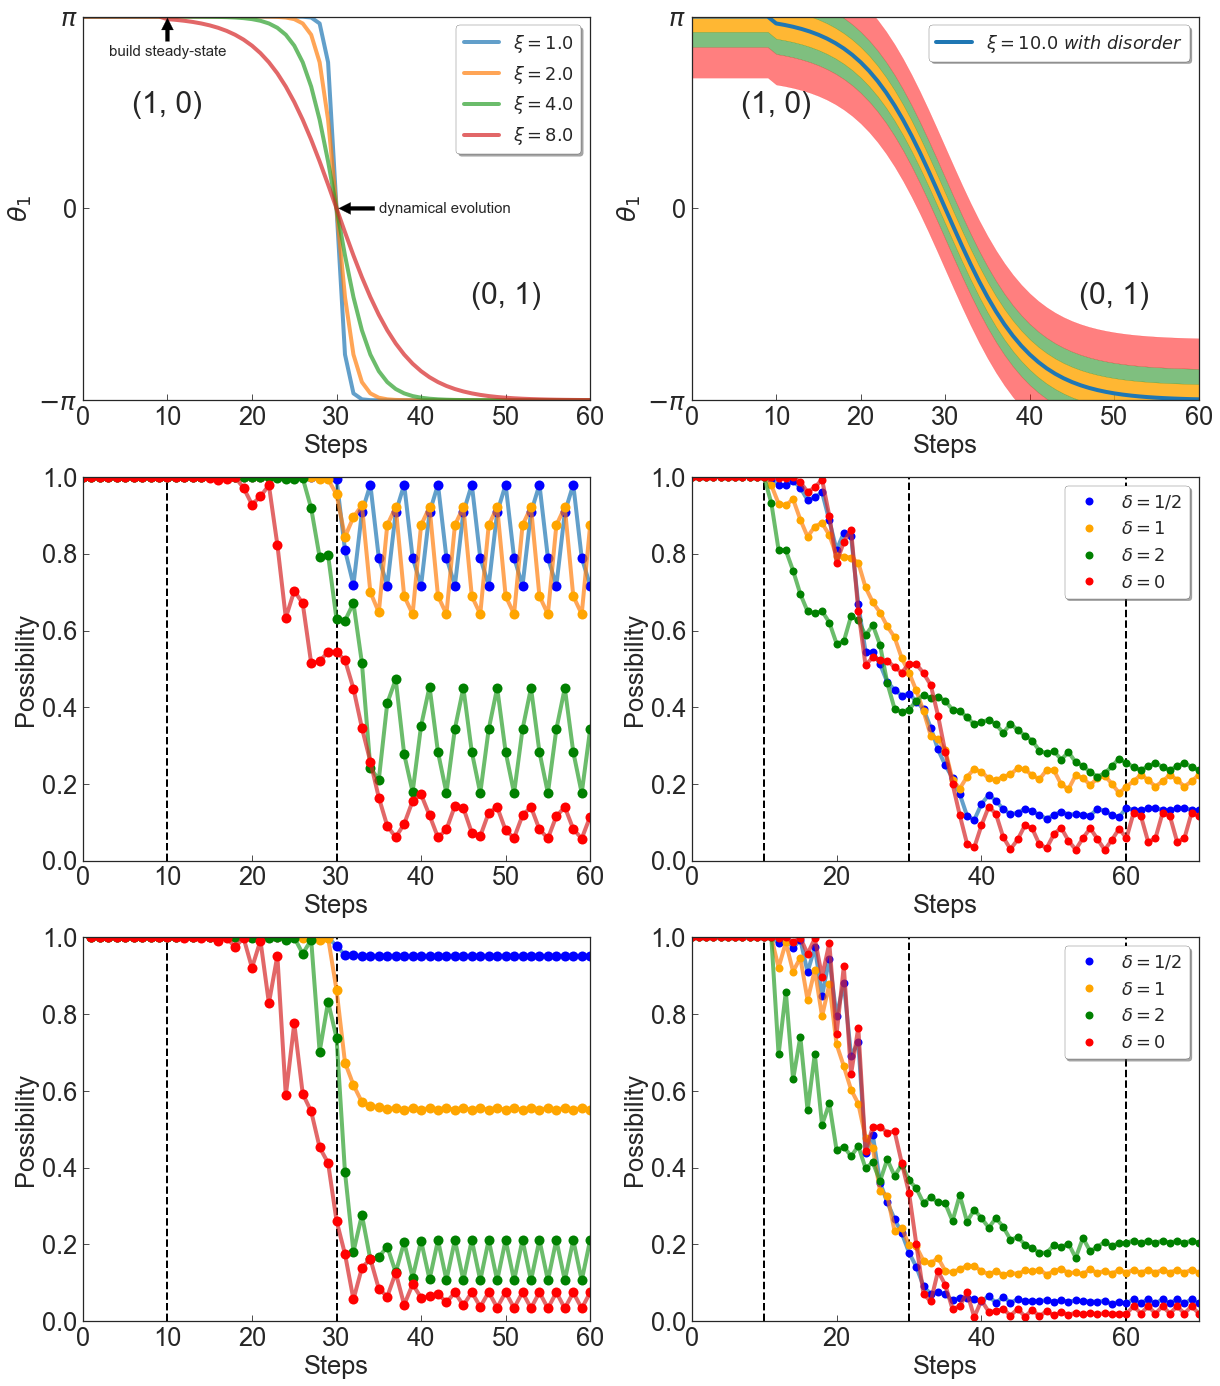

In [1463]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = -np.pi
theta_1 = np.pi/2
theta_2 = np.pi

n1=10
n2=20
n3=30
xi_1=1
xi_2=2
xi_3=4
xi_4=8

p_1 = np.zeros(M+1)
p_2 = np.zeros(M+1)
p_3 = np.zeros(M+1)
p_4 = np.zeros(M+1)

 
p_1[0]=1
p_2[0]=1
p_3[0]=1
p_4[0]=1

plt.figure(figsize=(20,24))
plt.subplot(3,2,1)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢
n = 30
def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,n1+n2+n3+1)
th_1 = np.zeros(n1+n2+n3+1)
th_1[0:n1] = theta_2*np.ones(n1)
th_2 = np.zeros(n1+n2+n3+1)
th_2[0:n1] = theta_2*np.ones(n1)
th_3 = np.zeros(n1+n2+n3+1)
th_3[0:n1] = theta_2*np.ones(n1)
th_4 = np.zeros(n1+n2+n3+1)
th_4[0:n1] = theta_2*np.ones(n1)
for i,t in enumerate(T[n1-1:-1]):
    th_1[i+n1] = f(t, theta_3, theta_2, xi_1, n1+n2-1)
    th_2[i+n1] = f(t, theta_3, theta_2, xi_2, n1+n2-1)
    th_3[i+n1] = f(t, theta_3, theta_2, xi_3, n1+n2-1)
    th_4[i+n1] = f(t, theta_3, theta_2, xi_4, n1+n2-1)
plt.xlim(0,60)
plt.ylim(-np.pi, np.pi)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([-np.pi, np.pi, 0], (r'$-\pi$', r'$\pi$', '0'))
plt.plot(T,th_1,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_1))
plt.plot(T,th_2,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_2))
plt.plot(T,th_3,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_3))
plt.plot(T,th_4,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_4))
plt.annotate('build steady-state', xy=(10, np.pi),xytext=(10, 2.5),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15,ha='center',)
plt.annotate('dynamical evolution', xy=(30, 0),xytext=(35, 0),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15,va='center',)
plt.text(10, np.pi/2, '(1, 0)', ha='center', fontsize=30)
plt.text(50, -np.pi/2, '(0, 1)', ha='center', fontsize=30)
plt.legend()

plt.subplot(3,2,3)

for i in range(n1): 
    if (i == 0):
        state1 = one_step_4(init_state, theta_1, theta_2)
        state2 = one_step_4(init_state, theta_1, theta_2)
        state3 = one_step_4(init_state, theta_1, theta_2)
        state4 = one_step_4(init_state, theta_1, theta_2)
    else:
        state1 = one_step_4(state1, theta_1, theta_2)
        state2 = one_step_4(state2, theta_1, theta_2) 
        state3 = one_step_4(state3, theta_1, theta_2) 
        state4 = one_step_4(state4, theta_1, theta_2) 
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+1] = P1[0] + P1[1]
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+1] = P1[0] + P1[1] 
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+1] = P3[0] + P3[1] 
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+1] = P4[0] + P4[1] 


for i in range(n2):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_1))       
    state1 = one_step_4(state1, theta_1, t1)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+1] = P1[0] + P1[1]
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_2))       
    state2 = one_step_4(state2, theta_1, t2)
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_3))       
    state3 = one_step_4(state3, theta_1, t3)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_4))       
    state4 = one_step_4(state4, theta_1, t4)
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+1] = P4[0] + P4[1]
    
for i in range(n3):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_1))     
    state1 = one_step_4(state1, theta_1, t1)   
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+n2+1] = P1[0] + P1[1]  
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_2))     
    state2 = one_step_4(state2, theta_1, t2)   
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+n2+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_3))     
    state3 = one_step_4(state3, theta_1, t3)   
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+n2+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_4))     
    state4 = one_step_4(state4, theta_1, t4)   
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+n2+1] = P4[0] + P4[1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_1[0:n1+n2+n3+1],'bo',ms=10,c='blue')
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_2[0:n1+n2+n3+1],'bo',ms=10,c='orange')
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_3[0:n1+n2+n3+1],'bo',ms=10,c='green')
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_4[0:n1+n2+n3+1],'bo',ms=10,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel('Possibility')
plt.xlabel('Steps')


import random
M = 200
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))



dis=1
xi=10
n=20



p_1 = np.zeros(n1+n2+n3+n4+1)
p_2 = np.zeros(n1+n2+n3+n4+1)
p_3 = np.zeros(n1+n2+n3+n4+1)
p_4 = np.zeros(n1+n2+n3+n4+1)


plt.subplot(3,2,2)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢

def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,n1+n2+n3+1)
th = np.zeros(n1+n2+n3+1)
th[0:n1] = theta_2*np.ones(n1)
for i,t in enumerate(T[n1-1:-1]):
    th[i+n1] = f(t, theta_3, theta_2, xi, n1+n2-1)
plt.xlim(0,60)
plt.ylim(-np.pi, np.pi)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([-np.pi, np.pi, 0], (r'$-\pi$', r'$\pi$', '0'))
plt.plot(T,th,lw=4,label=r'$\xi=%.1f\ with\ disorder$'%(xi))
plt.fill_between(T, th+dis_1/4, th-dis_1/4, color='orange', alpha=0.8)
plt.fill_between(T, th+dis_1/4, th+dis_1/2, color='green', alpha=0.5)
plt.fill_between(T, th-dis_1/4, th-dis_1/2, color='green', alpha=0.5)
plt.fill_between(T, th+dis_1/2, th+dis_1, color='red', alpha=0.5)
plt.fill_between(T, th-dis_1/2, th-dis_1, color='red', alpha=0.5) 
plt.text(10, np.pi/2, '(1, 0)', ha='center', fontsize=30)
plt.text(50, -np.pi/2, '(0, 1)', ha='center', fontsize=30)
plt.legend()

plt.subplot(3,2,4)



def f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p, dis):
    for i in range(n1): 
        if (i == 0):
            state = one_step_4(init_state, theta_1, theta_2)
        else:
            state = one_step_4(state, theta_1, theta_2)
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+1] = P[0] + P[1]
    for i in range(n2):
        t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi))       
        state = one_step_4(state, theta_1, t+random.uniform(-dis,dis))
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+n1+1] = P[0] + P[1]
    for i in range(n3):
        t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi))     
        state = one_step_4(state, theta_1, t+random.uniform(-dis,dis))   
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+n1+n2+1] = P[0] + P[1]
    for i in range(n4): 
        state = one_step_4(state, theta_1, theta_2)
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+n1+n2+n3+1] = P[0] + P[1]
    return p
T = range(n1+n2+n3+n4+1)

p1=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p1[i][0]=1
for i in range(n):
    p_1 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], 0) + p_1
    
p2=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p2[i][0]=1
for i in range(n):
    p_2 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis) + p_2

p3=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p3[i][0]=1
for i in range(n):
    p_3 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*2) + p_3

p4=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p4[i][0]=1
for i in range(n):
    p_4 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*4) + p_4
plt.plot(T, p_2/n,lw=4,alpha=0.7,)
plt.plot(T, p_2/n,'bo',ms=8,c='blue',label=r'$\delta=1/2$')
plt.plot(T, p_3/n,lw=4,alpha=0.7)
plt.plot(T, p_3/n,'bo',ms=8,c='orange',label=r'$\delta=1$')
plt.plot(T, p_4/n,lw=4,alpha=0.7)
plt.plot(T, p_4/n,'bo',ms=8,c='green',label=r'$\delta=2$')
plt.plot(T, p_1/n,lw=4,alpha=0.7)
plt.plot(T, p_1/n,'bo',ms=8,c='red',label=r'$\delta=0$')
plt.xlim((0,n1+n2+n3+n4))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2+n3, 0, 1, linestyles = "dashed")
plt.xlabel('Steps')
plt.ylabel('Possibility')
plt.legend()


plt.subplot(3,2,5)

theta_3 = -np.pi
theta_1 = 0
theta_2 = np.pi

for i in range(n1): 
    if (i == 0):
        state1 = one_step_4(init_state, theta_1, theta_2)
        state2 = one_step_4(init_state, theta_1, theta_2)
        state3 = one_step_4(init_state, theta_1, theta_2)
        state4 = one_step_4(init_state, theta_1, theta_2)
    else:
        state1 = one_step_4(state1, theta_1, theta_2)
        state2 = one_step_4(state2, theta_1, theta_2) 
        state3 = one_step_4(state3, theta_1, theta_2) 
        state4 = one_step_4(state4, theta_1, theta_2) 
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+1] = P1[0] + P1[1]
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+1] = P1[0] + P1[1] 
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+1] = P3[0] + P3[1] 
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+1] = P4[0] + P4[1] 


for i in range(n2):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_1))       
    state1 = one_step_4(state1, theta_1, t1)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+1] = P1[0] + P1[1]
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_2))       
    state2 = one_step_4(state2, theta_1, t2)
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_3))       
    state3 = one_step_4(state3, theta_1, t3)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_4))       
    state4 = one_step_4(state4, theta_1, t4)
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+1] = P4[0] + P4[1]
    
for i in range(n3):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_1))     
    state1 = one_step_4(state1, theta_1, t1)   
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+n2+1] = P1[0] + P1[1]  
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_2))     
    state2 = one_step_4(state2, theta_1, t2)   
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+n2+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_3))     
    state3 = one_step_4(state3, theta_1, t3)   
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+n2+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_4))     
    state4 = one_step_4(state4, theta_1, t4)   
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+n2+1] = P4[0] + P4[1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_1[0:n1+n2+n3+1],'bo',ms=10,c='blue')
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_2[0:n1+n2+n3+1],'bo',ms=10,c='orange')
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_3[0:n1+n2+n3+1],'bo',ms=10,c='green')
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_4[0:n1+n2+n3+1],'bo',ms=10,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel('Possibility')
plt.xlabel('Steps')

plt.subplot(3,2,6)
T = range(n1+n2+n3+n4+1)
n=20
dis=1

p_1 = np.zeros(n1+n2+n3+n4+1)
p_2 = np.zeros(n1+n2+n3+n4+1)
p_3 = np.zeros(n1+n2+n3+n4+1)
p_4 = np.zeros(n1+n2+n3+n4+1)
p1=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p1[i][0]=1
for i in range(n):
    p_1 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], 0) + p_1
    
p2=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p2[i][0]=1
for i in range(n):
    p_2 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis) + p_2

p3=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p3[i][0]=1
for i in range(n):
    p_3 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*2) + p_3

p4=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p4[i][0]=1
for i in range(n):
    p_4 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*4) + p_4

plt.plot(T, p_2/n,lw=4,alpha=0.7,)
plt.plot(T, p_2/n,'bo',ms=8,c='blue',label=r'$\delta=1/2$')
plt.plot(T, p_3/n,lw=4,alpha=0.7)
plt.plot(T, p_3/n,'bo',ms=8,c='orange',label=r'$\delta=1$')
plt.plot(T, p_4/n,lw=4,alpha=0.7)
plt.plot(T, p_4/n,'bo',ms=8,c='green',label=r'$\delta=2$')
plt.plot(T, p_1/n,lw=4,alpha=0.7)
plt.plot(T, p_1/n,'bo',ms=8,c='red',label=r'$\delta=0$')
plt.xlim((0,n1+n2+n3+n4))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2+n3, 0, 1, linestyles = "dashed")
plt.xlabel('Steps')
plt.ylabel('Possibility')
plt.legend()
plt.savefig('../fig/bound_state_5.pdf')


# 相邻的区域

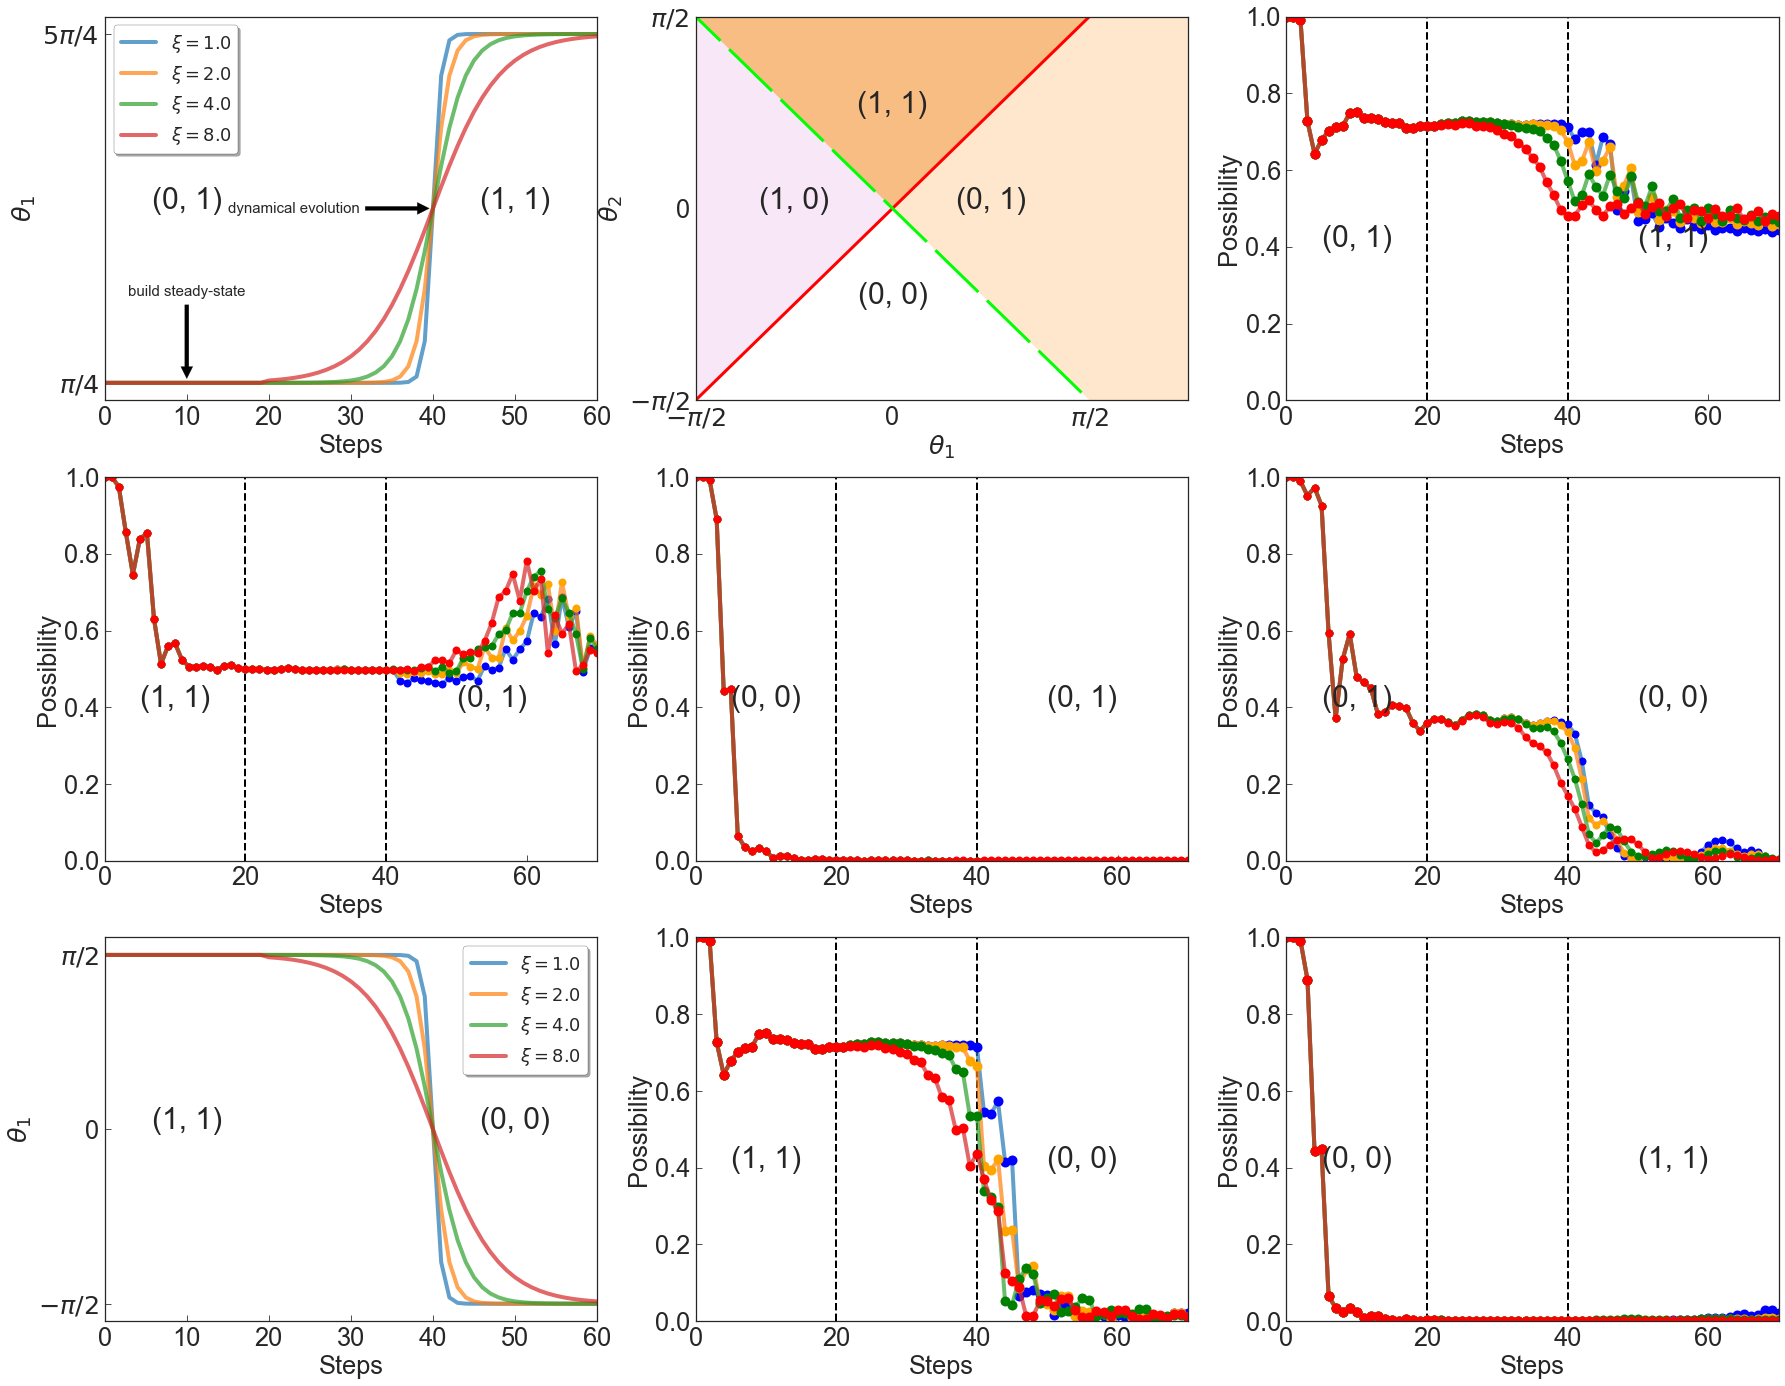

In [1526]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = 5*np.pi/4
theta_1 = np.pi/2
theta_2 = np.pi/4
n1=20
n2=20
n3=30
n4=10
xi_1=1
xi_2=2
xi_3=4
xi_4=8

p_1 = np.zeros(M+1)
p_2 = np.zeros(M+1)
p_3 = np.zeros(M+1)
p_4 = np.zeros(M+1)

 
p_1[0]=1
p_2[0]=1
p_3[0]=1
p_4[0]=1

plt.figure(figsize=(30,24))
plt.subplot(3,3,1)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢

def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,n1+n2+n3+1)
th_1 = np.zeros(n1+n2+n3+1)
th_1[0:n1] = theta_2*np.ones(n1)
th_2 = np.zeros(n1+n2+n3+1)
th_2[0:n1] = theta_2*np.ones(n1)
th_3 = np.zeros(n1+n2+n3+1)
th_3[0:n1] = theta_2*np.ones(n1)
th_4 = np.zeros(n1+n2+n3+1)
th_4[0:n1] = theta_2*np.ones(n1)
for i,t in enumerate(T[n1-1:-1]):
    th_1[i+n1] = f(t, theta_3, theta_2, xi_1, n1+n2-1)
    th_2[i+n1] = f(t, theta_3, theta_2, xi_2, n1+n2-1)
    th_3[i+n1] = f(t, theta_3, theta_2, xi_3, n1+n2-1)
    th_4[i+n1] = f(t, theta_3, theta_2, xi_4, n1+n2-1)
plt.xlim(0,60)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([np.pi/4, 5*np.pi/4, 0], (r'$\pi/4$', r'$5\pi/4$', '0'))
plt.plot(T,th_1,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_1))
plt.plot(T,th_2,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_2))
plt.plot(T,th_3,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_3))
plt.plot(T,th_4,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_4))
plt.annotate('build steady-state', xy=(10, np.pi/4),xytext=(10, np.pi/2),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15,ha='center',)
plt.annotate('dynamical evolution', xy=(40, 3*np.pi/4),xytext=(15, 3*np.pi/4),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15,va='center',)
plt.text(10, 3*np.pi/4, '(0, 1)', ha='center', fontsize=30)
plt.text(50, 3*np.pi/4, '(1, 1)', ha='center', fontsize=30)
plt.legend()

plt.subplot(3,3,3)

def neighbour(theta_1, theta_2, theta_3, init_state):
    p_1 = np.zeros(M+1)
    p_2 = np.zeros(M+1)
    p_3 = np.zeros(M+1)
    p_4 = np.zeros(M+1)
    p_1[0]=1
    p_2[0]=1
    p_3[0]=1
    p_4[0]=1
    for i in range(n1): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
            state2 = one_step_4(init_state, theta_1, theta_2)
            state3 = one_step_4(init_state, theta_1, theta_2)
            state4 = one_step_4(init_state, theta_1, theta_2)
        else:
            state1 = one_step_4(state1, theta_1, theta_2)
            state2 = one_step_4(state2, theta_1, theta_2) 
            state3 = one_step_4(state3, theta_1, theta_2) 
            state4 = one_step_4(state4, theta_1, theta_2) 
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+1] = P1[0] + P1[1] 
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+1] = P3[0] + P3[1] 
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+1] = P4[0] + P4[1] 


    for i in range(n2):
        t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_1))       
        state1 = one_step_4(state1, theta_1, t1)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+1] = P1[0] + P1[1]
        t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_2))       
        state2 = one_step_4(state2, theta_1, t2)
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_3))       
        state3 = one_step_4(state3, theta_1, t3)
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_4))       
        state4 = one_step_4(state4, theta_1, t4)
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+1] = P4[0] + P4[1]

    for i in range(n3):
        t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_1))     
        state1 = one_step_4(state1, theta_1, t1)   
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+n2+1] = P1[0] + P1[1]  
        t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_2))     
        state2 = one_step_4(state2, theta_1, t2)   
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+n2+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_3))     
        state3 = one_step_4(state3, theta_1, t3)   
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+n2+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_4))     
        state4 = one_step_4(state4, theta_1, t4)   
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+n2+1] = P4[0] + P4[1]
    return p_1,p_2,p_3,p_4

def Neighbour(theta_1, theta_2, theta_3, init_state):
    p_1 = np.zeros(M+1)
    p_2 = np.zeros(M+1)
    p_3 = np.zeros(M+1)
    p_4 = np.zeros(M+1)
    p_1[0]=1
    p_2[0]=1
    p_3[0]=1
    p_4[0]=1
    for i in range(n1): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
            state2 = one_step_4(init_state, theta_1, theta_2)
            state3 = one_step_4(init_state, theta_1, theta_2)
            state4 = one_step_4(init_state, theta_1, theta_2)
        else:
            state1 = one_step_4(state1, theta_1, theta_2)
            state2 = one_step_4(state2, theta_1, theta_2) 
            state3 = one_step_4(state3, theta_1, theta_2) 
            state4 = one_step_4(state4, theta_1, theta_2) 
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+1] = P1[0] + P1[1] 
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+1] = P3[0] + P3[1] 
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+1] = P4[0] + P4[1] 


    for i in range(n2):
        t1 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_1))       
        state1 = one_step_4(state1, t1, theta_2)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+1] = P1[0] + P1[1]
        t2 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_2))       
        state2 = one_step_4(state2, t2, theta_2)
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_3))       
        state3 = one_step_4(state3, t3, theta_2)
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_4))       
        state4 = one_step_4(state4, t4, theta_2)
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+1] = P4[0] + P4[1]

    for i in range(n3):
        t1 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_1))     
        state1 = one_step_4(state1, t1, theta_2)   
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+n2+1] = P1[0] + P1[1]  
        t2 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_2))     
        state2 = one_step_4(state2, t2, theta_2)   
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+n2+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_3))     
        state3 = one_step_4(state3, t3, theta_2)   
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+n2+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_4))     
        state4 = one_step_4(state4, t4, theta_2)   
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+n2+1] = P4[0] + P4[1]
    return p_1,p_2,p_3,p_4

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4,alpha=0.7)
plt.plot(T, p_1,'bo',ms=10,c='blue')
plt.plot(T, p_2,lw=4,alpha=0.7)
plt.plot(T, p_2,'bo',ms=10,c='orange')
plt.plot(T, p_3,lw=4,alpha=0.7)
plt.plot(T, p_3,'bo',ms=10,c='green')
plt.plot(T, p_4,lw=4,alpha=0.7)
plt.plot(T, p_4,'bo',ms=10,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.text(55, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.ylabel('Possibility')
plt.xlabel('Steps')


plt.subplot(3,3,2)

plt.xlim((-np.pi/2, 5*np.pi/4-np.pi/2))
plt.xticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
T4 = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(T4, T4, c='r', linewidth=3)
line_6, = plt.plot(T1, -T1, c='#00FF00', linewidth=3, linestyle="-")
line_6.set_dashes((20,4))
plt.fill([0, -np.pi/2, np.pi/2], [0, np.pi/2, np.pi/2], color='#F8BD82')
plt.fill([0, np.pi/2, 3*np.pi/4, 3*np.pi/4, np.pi/2], [0, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2], color='#FFE7CE')
plt.fill([0, np.pi/2, -2*np.pi], [0, -np.pi/2, -np.pi/2], color='w')
plt.fill([0, -np.pi/2, -np.pi/2], [0, np.pi/2, -np.pi/2], c='#F7E7F7')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.text(0, np.pi/4, '(1, 1)', ha='center', fontsize=30)
plt.text(-np.pi/4, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(np.pi/4, 0, '(0, 1)', ha='center', fontsize=30)
plt.text(0, -np.pi/4, '(0, 0)', ha='center', fontsize=30)
A=[np.pi/4, np.pi/2]
B=[np.pi/4, -np.pi/2]

plt.subplot(3,3,4)
theta_3 = np.pi/4
theta_1 = np.pi/2
theta_2 = 5*np.pi/4

n1=20
n2=20
n3=30
n4=10

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_1[0:n1+n2+n3+1],'bo',ms=8,c='blue')
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_2[0:n1+n2+n3+1],'bo',ms=8,c='orange')
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_3[0:n1+n2+n3+1],'bo',ms=8,c='green')
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_4[0:n1+n2+n3+1],'bo',ms=8,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel('Possibility')
plt.xlabel('Steps')
plt.text(10, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.text(55, 0.4, '(0, 1)', ha='center', fontsize=30)


plt.subplot(3,3,5)
theta_3 = 3*np.pi/4
theta_1 = -np.pi/2
theta_2 = np.pi/4

n1=20
n2=20
n3=30
n4=10

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_1[0:n1+n2+n3+1],'bo',ms=8,c='blue')
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_2[0:n1+n2+n3+1],'bo',ms=8,c='orange')
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_3[0:n1+n2+n3+1],'bo',ms=8,c='green')
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_4[0:n1+n2+n3+1],'bo',ms=8,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel('Possibility')
plt.xlabel('Steps')
plt.text(10, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.text(55, 0.4, '(0, 1)', ha='center', fontsize=30)

plt.subplot(3,3,6)
theta_3 = np.pi/4
theta_1 = -np.pi/2
theta_2 = 3*np.pi/4

n1=20
n2=20
n3=30
n4=10

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_1[0:n1+n2+n3+1],'bo',ms=8,c='blue')
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_2[0:n1+n2+n3+1],'bo',ms=8,c='orange')
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_3[0:n1+n2+n3+1],'bo',ms=8,c='green')
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4,alpha=0.7)
plt.plot(T, p_4[0:n1+n2+n3+1],'bo',ms=8,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel('Possibility')
plt.xlabel('Steps')
plt.text(10, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.text(55, 0.4, '(0, 0)', ha='center', fontsize=30)

plt.subplot(3,3,7)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢
theta_2 = np.pi/4
theta_1 = np.pi/2
theta_3 = -np.pi/2


T = np.linspace(0,n1+n2+n3,n1+n2+n3+1)
th_1 = np.zeros(n1+n2+n3+1)
th_1[0:n1] = theta_1*np.ones(n1)
th_2 = np.zeros(n1+n2+n3+1)
th_2[0:n1] = theta_1*np.ones(n1)
th_3 = np.zeros(n1+n2+n3+1)
th_3[0:n1] = theta_1*np.ones(n1)
th_4 = np.zeros(n1+n2+n3+1)
th_4[0:n1] = theta_1*np.ones(n1)
for i,t in enumerate(T[n1-1:-1]):
    th_1[i+n1] = f(t, theta_3, theta_1, xi_1, n1+n2-1)
    th_2[i+n1] = f(t, theta_3, theta_1, xi_2, n1+n2-1)
    th_3[i+n1] = f(t, theta_3, theta_1, xi_3, n1+n2-1)
    th_4[i+n1] = f(t, theta_3, theta_1, xi_4, n1+n2-1)
plt.xlim(0,60)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([np.pi/2, -np.pi/2, 0], (r'$\pi/2$', r'$-\pi/2$', '0'))
plt.plot(T,th_1,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_1))
plt.plot(T,th_2,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_2))
plt.plot(T,th_3,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_3))
plt.plot(T,th_4,lw=4,alpha=0.7,label=r'$\xi=%.1f$'%(xi_4))
plt.text(10, 0, '(1, 1)', ha='center', fontsize=30)
plt.text(50, 0, '(0, 0)', ha='center', fontsize=30)
plt.legend()

plt.subplot(3,3,9)
theta_2 = np.pi/4
theta_1 = -np.pi/2
theta_3 = np.pi/2
p_1 =  Neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  Neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  Neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  Neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4,alpha=0.7)
plt.plot(T, p_1,'bo',ms=10,c='blue')
plt.plot(T, p_2,lw=4,alpha=0.7)
plt.plot(T, p_2,'bo',ms=10,c='orange')
plt.plot(T, p_3,lw=4,alpha=0.7)
plt.plot(T, p_3,'bo',ms=10,c='green')
plt.plot(T, p_4,lw=4,alpha=0.7)
plt.plot(T, p_4,'bo',ms=10,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.text(55, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.ylabel('Possibility')
plt.xlabel('Steps')

plt.subplot(3,3,8)
theta_2 = np.pi/4
theta_1 = np.pi/2
theta_3 = -np.pi/2
p_1 =  Neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  Neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  Neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  Neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4,alpha=0.7)
plt.plot(T, p_1,'bo',ms=10,c='blue')
plt.plot(T, p_2,lw=4,alpha=0.7)
plt.plot(T, p_2,'bo',ms=10,c='orange')
plt.plot(T, p_3,lw=4,alpha=0.7)
plt.plot(T, p_3,'bo',ms=10,c='green')
plt.plot(T, p_4,lw=4,alpha=0.7)
plt.plot(T, p_4,'bo',ms=10,c='red')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.text(55, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.ylabel('Possibility')
plt.xlabel('Steps')

plt.savefig('../fig/bound_state_6.pdf')

<Figure size 720x720 with 0 Axes>

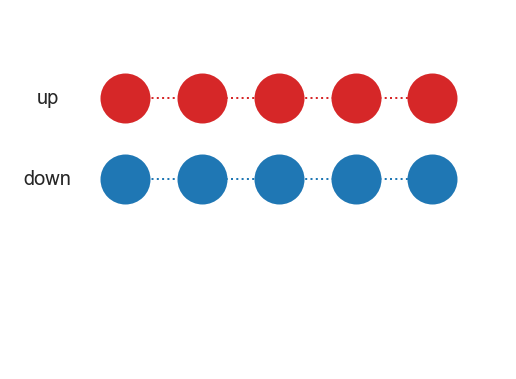

In [1538]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.figure(figsize=(10,10))
points = np.ones(5)  # Draw 5 points for each line
marker_style1 = dict(color='tab:blue', linestyle=':', marker='o',
                    markersize=50)

marker_style2 = dict(color='tab:red', linestyle=':', marker='o',
                    markersize=50)
fig, ax = plt.subplots()

ax.text(-1, 0, 'down',
            horizontalalignment='center', verticalalignment='center',fontsize =20)
ax.plot(0 * points, fillstyle='full', **marker_style1)

ax.text(-1, 0.1, 'up',
            horizontalalignment='center', verticalalignment='center',fontsize =20)
ax.plot(0.1 * points, fillstyle='full', **marker_style2)
ax.set_xlim((-0.8,5))
ax.set_ylim((-0.2,0.2))
ax.set_axis_off()
plt.savefig('../fig/transfer.pdf')
plt.show()